<a href="https://colab.research.google.com/github/GeorgeWilliam1999/Q-computing/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NEXT STEP
(to be updated every session)

Literature review

Summarise IRIS and penguin dataset finding in latex

Create lime using binary Quantum classifier

Finish class function

Improve the accuracy of the classifier:

1.   Try alternative Cost functions - Cross entrophy?




Quantum input data


Backpropagation methods





  



In [49]:
!pip install qulacs
!pip install lime
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [50]:
import qulacs
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from qulacs import Observable

import numpy as np
import seaborn as sns
import pandas as pd 


import sklearn
import sklearn.datasets
import sklearn.ensemble
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize #BFGS works well/cobyla

from matplotlib import pyplot as plt

import lime
import lime.lime_tabular


In [51]:
p = 0.49
while((1 - p) <  0.99):
  p = p**2/(p**2 + (1-p)**2)
  print(p)

0.4800079968012795
0.4600798148316336
0.42066534719655946
0.3452272453010868
0.2175211667612182
0.07173480446400259
0.005936491285257016


# Circuits

## Embedding

In [52]:
#Function to perform pointwise qubit embedding.

#The input to this function must be normalised between 0 and pi/2

#Qubit embedding
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

## Computational

In [53]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
#Circuit 6 Hur et al
def U_conv_6():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')

  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)

  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)

  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)  
  circuit.add_CNOT_gate(1,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)
  
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

In [54]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

# Classification Object

In [55]:
class MLP():

  def __init__(self,U,Embed):
    self.U = U()
    self.E = Embed
    self.theta = np.random.rand(self.U.get_parameter_count())
    self.classes = 0
    self.expectation_values = 0


  #Determine optimal parameter vector theta
  def train(self,X,y):
    '''print(self.theta)'''

    #Set initial theta to a a random set of numbers
    theta_0 = self.theta

    #Determine the number of classes
    classes = np.unique(y)
    self.classes = classes

    #Compute the expectation values of a data point
    def find_expectations(theta):  
      Expectations = np.zeros(X.shape[0])
      circuit = self.U

      j = 0
      for row in np.array(X):
        for i in range(circuit.get_parameter_count()):
          circuit.set_parameter(i,theta[i])
        #Define and embed data point, x is an element of the normalised data set
        point = row
        
        state = self.E(point)
        circuit.update_quantum_state(state)
        obs = Observable(4)
        obs.add_operator(1.,'Z 1')
        exp = obs.get_expectation_value(state)
        Expectations[j] = ((exp + 1)/2)*max(classes)
        j += 1

      return Expectations

    def MSE(theta):
      #get predictions

      Expectations = find_expectations(theta)
      #Simple MSE example
      
      #Expectation values
      L = ((Expectations - y)**2).mean()
      '''print(L)'''
      return L

    result = minimize(MSE, theta_0, method='cobyla')
    self.theta = result.x
    '''print(theta_0, self.theta)'''
    return self.theta

  def predict(self,X):
    classes = self.classes
     #Compute the expectation values of a data point
    def find_expectations(theta):  
      Expectations = np.zeros(X.shape[0])
      circuit = self.U

      j = 0
      for row in np.array(X):
        for i in range(circuit.get_parameter_count()):
          circuit.set_parameter(i,theta[i])
        #Define and embed data point, x is an element of the normalised data set
        point = row
        
        state = self.E(point)
        circuit.update_quantum_state(state)
        obs = Observable(4)
        obs.add_operator(1.,'Z 1')
        exp = obs.get_expectation_value(state)
        Expectations[j] = ((exp + 1)/2)*max(classes)
        j += 1
      
      return Expectations
    
    expectations = find_expectations(self.theta)
    self.expectation_values = expectations
    '''print(self.expectation_values)'''
    return expectations

  #Create probabilities for LIME using any classifier that has a method of the 
  #form clssifier.predict() which takes a single point a its argument

  ###Assign probabilities
  def create_probabilities(self,input_X):

    if input_X.ndim == 1:
      input_X = np.reshape(input_X,(1,input_X.shape[0]))
    
    expectation_values = self.predict(input_X)
    for i in range(input_X.shape[0]):
      probabilities = np.zeros((input_X.shape[0],3))
    for i in range(input_X.shape[0]):
      e = expectation_values[i]
      magnitude = 2*(np.abs(e-1)+np.abs(e-2)+np.abs(e-0))
      p_0 = (np.abs(e-1)+np.abs(e-2))/magnitude
      p_1 = (np.abs(e-0)+np.abs(e-2))/magnitude
      p_2 = (np.abs(e-1)+np.abs(e-0))/magnitude

      if (p_0 < p_1) & (p_0 < p_2):
        p_0 = 0
      if (p_1 < p_0) &( p_1 < p_2):
        p_1 = 0
      if (p_2 < p_0) & (p_2 < p_1):
        p_2 = 0

      probabilities[i,:] = np.array([p_0, p_1, p_2])
      probabilities[i,:] = probabilities[i,:]/(probabilities[i,:].sum())
      
    return probabilities



In [56]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

# Data Preparation

## Pingu


In [57]:
!ls 'drive/MyDrive/Data'
pingu = pd.read_csv("drive/MyDrive/Data/penguins.csv")

penguins.csv


In [88]:
pingu = pingu.iloc[:,:8].dropna()
pingu

species     island  bill_length_mm  ...  body_mass_g  sex  year
0          0  Torgersen            39.1  ...       3750.0    1     0
1          0  Torgersen            39.5  ...       3800.0    0     0
2          0  Torgersen            40.3  ...       3250.0    0     0
4          0  Torgersen            36.7  ...       3450.0    0     0
5          0  Torgersen            39.3  ...       3650.0    1     0
..       ...        ...             ...  ...          ...  ...   ...
339        1      Dream            55.8  ...       4000.0    1     2
340        1      Dream            43.5  ...       3400.0    0     2
341        1      Dream            49.6  ...       3775.0    1     2
342        1      Dream            50.8  ...       4100.0    1     2
343        1      Dream            50.2  ...       3775.0    0     2

[333 rows x 8 columns]

In [89]:
pingu_features = pingu.iloc[:,0].unique()

In [60]:
pingu_features

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [61]:
le = sklearn.preprocessing.LabelEncoder()

pingu['species'] = le.fit_transform(pingu['species'])
pingu['sex'] = le.fit_transform(pingu['sex'])
pingu['year'] = le.fit_transform(pingu['year'])

In [62]:
pingu.head()

species     island  bill_length_mm  ...  body_mass_g  sex  year
0        0  Torgersen            39.1  ...       3750.0    1     0
1        0  Torgersen            39.5  ...       3800.0    0     0
2        0  Torgersen            40.3  ...       3250.0    0     0
4        0  Torgersen            36.7  ...       3450.0    0     0
5        0  Torgersen            39.3  ...       3650.0    1     0

[5 rows x 8 columns]

In [63]:
#Load iris data and classification to the same array.
pingu_features = pingu.iloc[:,2:6].columns.values.tolist()
pingu_features.append('label')

X_train, X_test, y_train, y_test = train_test_split(pingu.iloc[:,2:6], pingu.iloc[:,0], test_size=0.33, random_state=42)
print(X_train, X_test, y_train, y_test)
pingu_train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
pingu_train_data[:,0:4] = X_train
pingu_train_data[:,4] = y_train
pingu_train_df = pd.DataFrame(data = pingu_train_data, columns = pingu_features)

pingu_test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
pingu_test_data[:,0:4] = X_test
pingu_test_data[:,4] = y_test
pingu_test_df = pd.DataFrame(data = pingu_test_data, columns = pingu_features)

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
44             37.0           16.9              185.0       3000.0
321            50.8           18.5              201.0       4450.0
110            38.1           16.5              198.0       3825.0
161            46.8           15.4              215.0       5150.0
200            44.9           13.3              213.0       5100.0
..              ...            ...                ...          ...
195            49.6           15.0              216.0       4750.0
77             37.2           19.4              184.0       3900.0
112            39.7           17.7              193.0       3200.0
281            45.2           17.8              198.0       3950.0
108            38.1           17.0              181.0       3175.0

[223 rows x 4 columns]      bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
30             39.5           16.7              178.0       3250.0
320            50.9           17.9    

In [64]:
pingu_train_df

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  label
0              37.0           16.9              185.0       3000.0    0.0
1              50.8           18.5              201.0       4450.0    1.0
2              38.1           16.5              198.0       3825.0    0.0
3              46.8           15.4              215.0       5150.0    2.0
4              44.9           13.3              213.0       5100.0    2.0
..              ...            ...                ...          ...    ...
218            49.6           15.0              216.0       4750.0    2.0
219            37.2           19.4              184.0       3900.0    0.0
220            39.7           17.7              193.0       3200.0    0.0
221            45.2           17.8              198.0       3950.0    1.0
222            38.1           17.0              181.0       3175.0    0.0

[223 rows x 5 columns]

## IRIS

In [65]:
#Load and view iris data set
iris = sklearn.datasets.load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [66]:
#Load iris data and classification to the same array.
iris_features = iris.feature_names
iris_features.append('label')

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

iris_train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
iris_train_data[:,0:4] = X_train
iris_train_data[:,4] = y_train
iris_train_df = pd.DataFrame(data = iris_train_data, columns = iris_features)

iris_test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
iris_test_data[:,0:4] = X_test
iris_test_data[:,4] = y_test
iris_test_df = pd.DataFrame(data = iris_test_data, columns = iris_features)

# IRIS Analysis

### Quantum

In [67]:
#Normalise test adn train data between 0 and pi/2 for qubit embedding

iris_train_df[iris_train_df.columns[:4]] -= iris_train_df[iris_train_df.columns[:4]].min()
iris_train_df[iris_train_df.columns[:4]] /= iris_train_df[iris_train_df.columns[:4]].max()
iris_train_df[iris_train_df.columns[:4]] *= np.pi/2


iris_test_df[iris_test_df.columns[:4]] -= iris_test_df[iris_test_df.columns[:4]].min()
iris_test_df[iris_test_df.columns[:4]] /= iris_test_df[iris_test_df.columns[:4]].max()
iris_test_df[iris_test_df.columns[:4]] *= np.pi/2


In [68]:
#Initialise classifier object

iris_classifier = MLP(U_conv_6,pointwise_qubit_embedding)

#Train classifier

iris_classifier.train(iris_train_df.iloc[:,0:4],iris_train_df.iloc[:,4])

#Find expectations

expectations = iris_classifier.predict(iris_test_df.iloc[:,0:4])

iris_classifier.create_probabilities(np.array(iris_test_df.iloc[0,:4]))

array([[0.        , 0.57554294, 0.42445706]])

In [69]:
#Check the accuracy of the predictions 
correct = 0

q_predictions = np.zeros(len(iris_test_df.iloc[:,0]))
for i in range(len(q_predictions)):
  q_predictions[i] = classify_tri(expectations[i])
  if q_predictions[i] == iris_test_df.iloc[i,4]:
    '''print(predictions[i]  iris_test_df.iloc[i,4])'''
    
    correct += 1

accuracy = (correct/len(q_predictions))*100

print('The trinary classification for the iris data set is ', accuracy ,'% accurate ')

The trinary classification for the iris data set is  92.0 % accurate 


In [70]:
confusion_matrix(q_predictions, iris_test_df.iloc[:,4])

array([[19,  0,  0],
       [ 0, 11,  0],
       [ 0,  4, 16]])

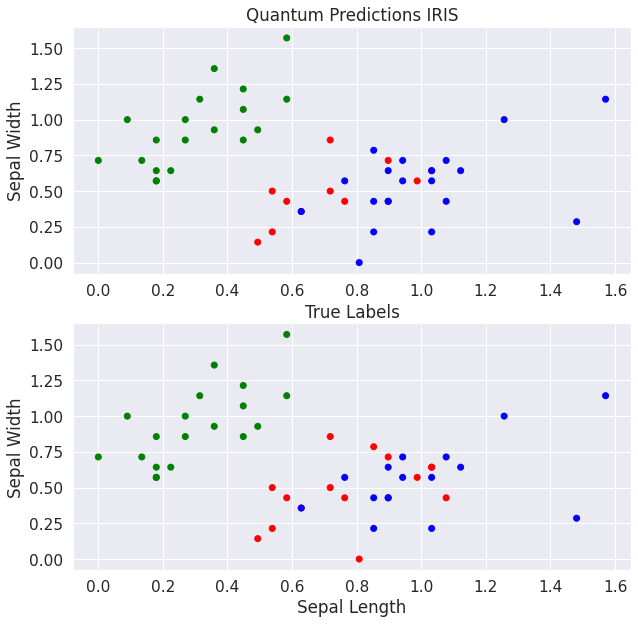

In [71]:
fig, ax = plt.subplots(2, figsize=(10, 10))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}


ax[0].scatter(iris_test_df.iloc[:,0],iris_test_df.iloc[:,1], c = pd.Series(q_predictions).map(colours))
ax[0].set_title("Quantum Predictions IRIS")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(iris_test_df.iloc[:,0],iris_test_df.iloc[:,1], c = iris_test_df[iris_test_df.columns[4]].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

### Classical

In [72]:
#Call model from sklearn
rfI = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rfI.fit(iris_train_df[iris_train_df.columns[:4]], iris_train_df[iris_train_df.columns[4]])
rfI_classical_predictions = rfI.predict(iris_test_df[iris_test_df.columns[:4]])

In [73]:
rfI.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [74]:
#Check the accuracy of the predictions 
correct = 0

rfI_predictions = np.zeros(len(iris_test_df.iloc[:,0]))
for i in range(len(rfI_predictions)):
  rfI_predictions[i] = rfI_classical_predictions[i]
  if rfI_predictions[i] == iris_test_df.iloc[i,4]:
    '''print(predictions[i]  iris_test_df.iloc[i,4])'''
    
    correct += 1

accuracy = (correct/len(rfI_predictions))*100

print('The trinary classification for the iris data set is ', accuracy ,'% accurate ')

The trinary classification for the iris data set is  98.0 % accurate 


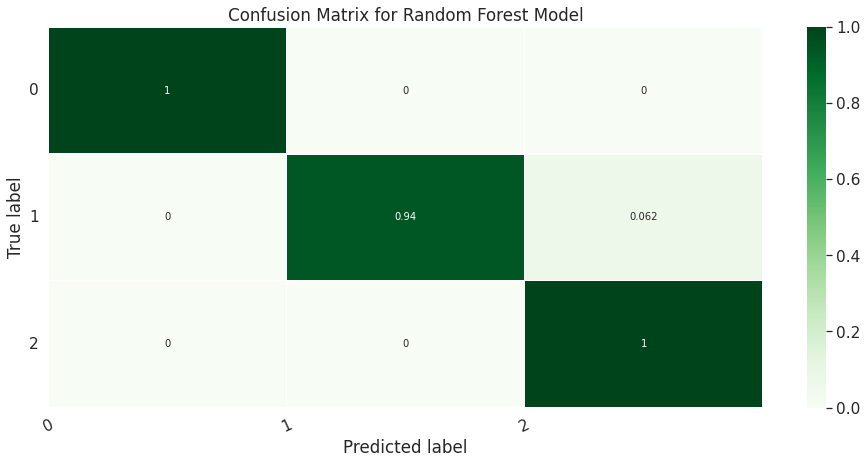

In [75]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(rfI_predictions, iris_test_df.iloc[:,4])
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [0,1,2]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

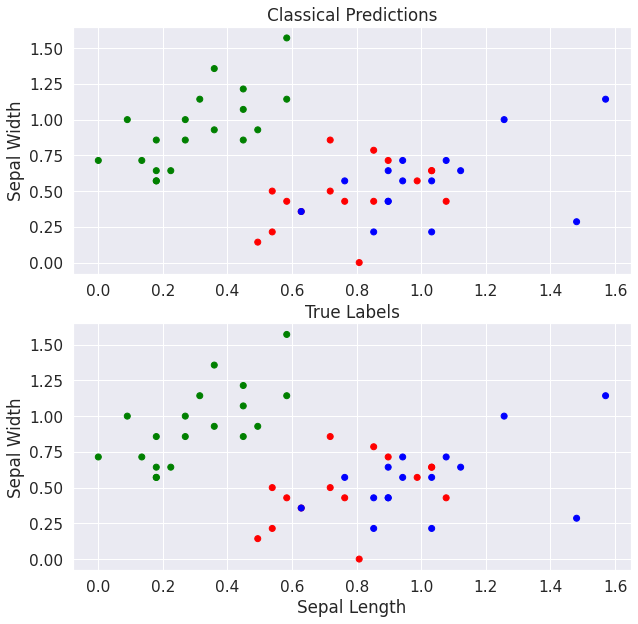

In [76]:
fig, ax = plt.subplots(2, figsize=(10, 10))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}


ax[0].scatter(iris_test_df.iloc[:,0],iris_test_df.iloc[:,1], c = pd.Series(rfI_predictions).map(colours))
ax[0].set_title("Classical Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(iris_test_df.iloc[:,0],iris_test_df.iloc[:,1], c = iris_test_df[iris_test_df.columns[4]].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

# Pingu Analysis

## Quantum

In [77]:
pingu_train_df

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  label
0              37.0           16.9              185.0       3000.0    0.0
1              50.8           18.5              201.0       4450.0    1.0
2              38.1           16.5              198.0       3825.0    0.0
3              46.8           15.4              215.0       5150.0    2.0
4              44.9           13.3              213.0       5100.0    2.0
..              ...            ...                ...          ...    ...
218            49.6           15.0              216.0       4750.0    2.0
219            37.2           19.4              184.0       3900.0    0.0
220            39.7           17.7              193.0       3200.0    0.0
221            45.2           17.8              198.0       3950.0    1.0
222            38.1           17.0              181.0       3175.0    0.0

[223 rows x 5 columns]

In [78]:
pingu_train_df[pingu_train_df.columns[0:4]] -= pingu_train_df[pingu_train_df.columns[0:4]].min()
pingu_train_df[pingu_train_df.columns[0:4]] /= pingu_train_df[pingu_train_df.columns[0:4]].max()
pingu_train_df[pingu_train_df.columns[0:4]] *= np.pi/2


pingu_test_df[pingu_test_df.columns[0:4]] -= pingu_test_df[pingu_test_df.columns[0:4]].min()
pingu_test_df[pingu_test_df.columns[0:4]] /= pingu_test_df[pingu_test_df.columns[0:4]].max()
pingu_test_df[pingu_test_df.columns[0:4]] *= np.pi/2

In [79]:
#Initialise classifier object

pingu_classifier = MLP(U_conv_6,pointwise_qubit_embedding)

#Train classifier

pingu_classifier.train(pingu_train_df.iloc[:,0:4],pingu_train_df.iloc[:,4])

#Find expectations

pingu_expectations = pingu_classifier.predict(pingu_test_df.iloc[:,0:4])

pingu_classifier.create_probabilities(np.array(pingu_test_df.iloc[0,0:4]))

array([[0.53811606, 0.46188394, 0.        ]])

In [80]:
#Check the accuracy of the predictions 
pingu_correct = 0

pingu_predictions = np.zeros(len(pingu_test_df.iloc[:,0]))
for i in range(len(pingu_predictions)):
  pingu_predictions[i] = classify_tri(pingu_expectations[i])
  if int(pingu_predictions[i]) == int(pingu_test_df.iloc[i,4]):
    
    
    pingu_correct += 1

accuracy = (pingu_correct/len(pingu_predictions))*100

print('The trinary classification for the iris data set is ', accuracy ,'% accurate ')

The trinary classification for the iris data set is  88.18181818181819 % accurate 


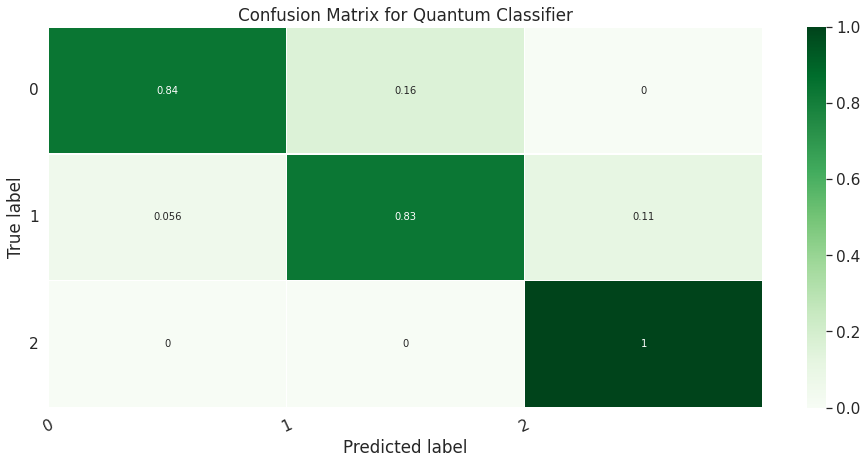

In [81]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(pingu_predictions, pingu_test_df.iloc[:,4])
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [0,1,2]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Quantum Classifier')
plt.show()

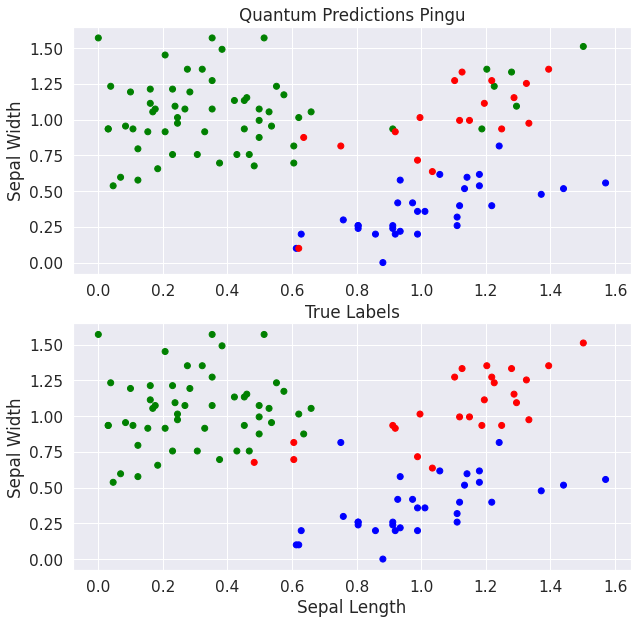

In [82]:
fig, ax = plt.subplots(2, figsize=(10, 10))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}

ax[0].scatter(pingu_test_df.iloc[:,0],pingu_test_df.iloc[:,1], c = pd.Series(pingu_predictions).map(colours))
ax[0].set_title("Quantum Predictions Pingu")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(pingu_test_df.iloc[:,0],pingu_test_df.iloc[:,1], c = pingu_test_df[pingu_test_df.columns[4]].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

## Classical

In [83]:
#Call model from sklearn
p_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
p_rf.fit(pingu_train_df[pingu_train_df.columns[:4]], pingu_train_df[pingu_train_df.columns[4]])
pingu_classical_predictions = p_rf.predict(pingu_test_df[pingu_test_df.columns[:4]])

In [84]:
#Check the accuracy of the predictions 
correct = 0

rfp_predictions = np.zeros(len(pingu_test_df.iloc[:,0]))
for i in range(len(rfp_predictions)):
  rfp_predictions[i] = pingu_classical_predictions[i]
  if rfp_predictions[i] == pingu_test_df.iloc[i,4]:
    '''print(predictions[i]  iris_test_df.iloc[i,4])'''
    
    correct += 1

accuracy = (correct/len(rfp_predictions))*100

print('The trinary classification for the iris data set is ', accuracy ,'% accurate ')

The trinary classification for the iris data set is  96.36363636363636 % accurate 


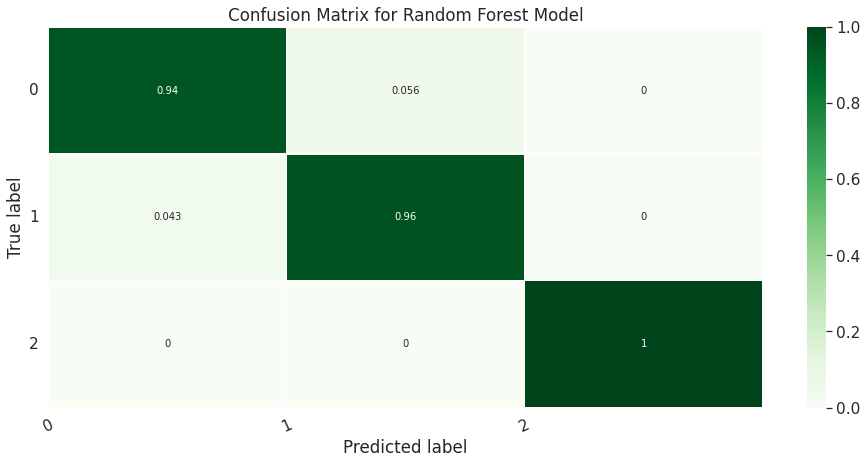

In [85]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(rfp_predictions, pingu_test_df.iloc[:,4])
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [0,1,2]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [86]:
pingu_test_df

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  label
0          0.375459       0.695922           0.112200     0.161700    0.0
1          1.248975       0.934524           0.617099     0.358049    1.0
2          0.574682       1.173126           0.589049     0.508199    0.0
3          0.919491       0.198835           1.009798     0.900898    2.0
4          0.498057       0.994175           0.504899     0.531299    0.0
..              ...            ...                ...          ...    ...
105        0.153248       0.914641           0.308549     0.369599    0.0
106        1.371573       0.477204           1.318347     1.178097    2.0
107        1.180013       0.536854           1.402497     1.131897    2.0
108        0.176236       1.073709           0.420749     0.277199    0.0
109        0.927153       0.417553           1.262247     1.062598    2.0

[110 rows x 5 columns]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


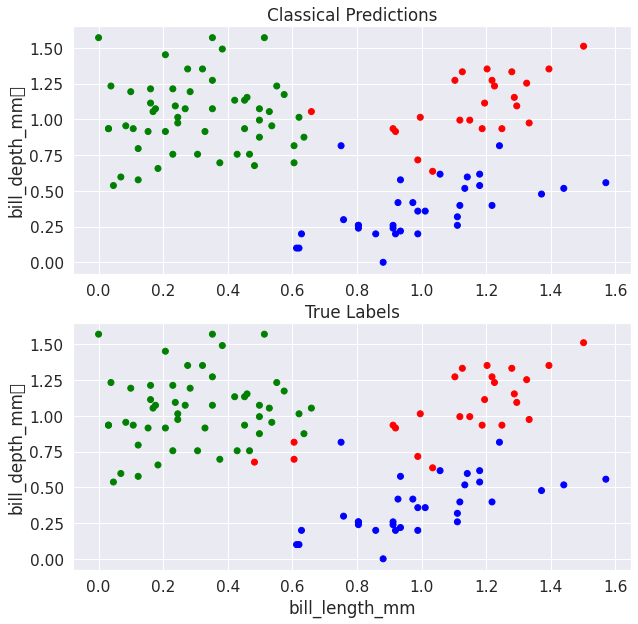

In [87]:
fig, ax = plt.subplots(2, figsize=(10, 10))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}


ax[0].scatter(pingu_test_df.iloc[:,0],pingu_test_df.iloc[:,1], c = pd.Series(pingu_classical_predictions).map(colours))
ax[0].set_title("Classical Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("bill_depth_mm	")

ax[1].scatter(pingu_test_df.iloc[:,0],pingu_test_df.iloc[:,1], c = pingu_test_df[pingu_test_df.columns[4]].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("bill_length_mm")
ax[1].set_ylabel("bill_depth_mm	")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

# LIME on IRIS

## Quantum 

In [ ]:
q_explainer = lime.lime_tabular.LimeTabularExplainer(iris_test_df.iloc[:,:4].values, feature_names=iris_test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
q_exp = q_explainer.explain_instance(iris_test_df.iloc[:,:4].values[42], iris_classifier.create_probabilities, num_features=2, top_labels=3)


q_exp.show_in_notebook(show_table=True, show_all=True)

## Classical 



In [ ]:
origional_explainer = lime.lime_tabular.LimeTabularExplainer(iris_test_df.iloc[:,:4].values, feature_names=iris_test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
origional_exp = origional_explainer.explain_instance(iris_test_df.iloc[:,:4].values[42], rfI.predict_proba, num_features=2, top_labels=3)

origional_exp.show_in_notebook(show_table=True, show_all=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


# LIME on Pingu

## Quantum 

In [ ]:
pingu_features = pingu.iloc[:,0].unique()

In [90]:
q_explainer = lime.lime_tabular.LimeTabularExplainer(pingu_test_df.iloc[:,:4].values, feature_names=pingu_test_df.columns[:4], class_names=pingu_features, discretize_continuous=True)
q_exp = q_explainer.explain_instance(pingu_test_df.iloc[:,:4].values[49], iris_classifier.create_probabilities, num_features=2, top_labels=3)


q_exp.show_in_notebook(show_table=True, show_all=True)

In [ ]:
pingu_test_df.iloc[:,:].values[49], pingu_features

(array([1.10338864, 1.27254386, 1.06589751, 0.64679849, 1.        ]),
 array([0, 2, 1]))

## Classical

In [91]:
origional_explainer = lime.lime_tabular.LimeTabularExplainer(pingu_test_df.iloc[:,:4].values, feature_names=pingu_test_df.columns[:4], class_names=pingu_features, discretize_continuous=True)
origional_exp = origional_explainer.explain_instance(pingu_test_df.iloc[:,:4].values[49], p_rf.predict_proba, num_features=2, top_labels=3)

origional_exp.show_in_notebook(show_table=True, show_all=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


# QML --- DRAFT
## Parameterised quantum circuit set up

Starting goal circuit:
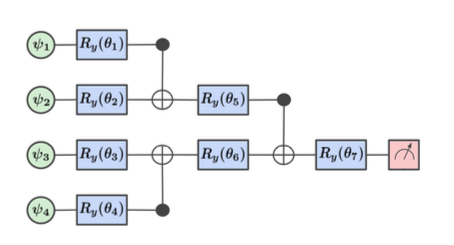

This circuit is able to perform binary classification of data. The anzats is convolutional which helps avoid the barren plat. which can prevent the variational circuit from being optermised

## Penguin data processing

In [ ]:
!ls 'drive/MyDrive/Data'

In [ ]:
pingu = pd.read_csv("drive/MyDrive/Data/penguins.csv")

In [ ]:
pingu = pingu[pingu.columns[0:4]]

In [ ]:
pingu.head()

## Iris data processing

In [ ]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

In [ ]:
iris.data.shape,iris.target.shape

In [ ]:
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

In [ ]:
iris_df = pd.DataFrame(data = data, columns = features)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)

Featurewise pair plots:

In [ ]:
sns.pairplot(iris_df, hue="label", palette = 'deep')

## Data preprocessing, embedding and computational circuit

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

### Preprocessing

Test train split:

In [ ]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)

  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]

  largest_values = np.zeros(dim)
  
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])


  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

Rescaled to be between 0 and pi/2 using pandas dataframe functions

In [ ]:
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()
train_df[train_df.columns[:4]] *= np.pi/2

In [ ]:
train_df.head()

In [ ]:
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2

In [ ]:
test_df.head()

In [ ]:
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

### Embedding circuit (Qubit Embedding)

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [ ]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

### Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

In [ ]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
#Circuit 6 Hur et al
def U_conv_6():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)  
  circuit.add_CNOT_gate(1,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

In [ ]:
circuit = U_conv_6()
circuit.get_parameter_count

In [ ]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

## Get expectation

The below function will return the expectation scaled between 2 and 0.

In [ ]:
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  return exp + 1

# Trinary Clasification

In [ ]:
from qulacs import Observable

In [ ]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

## prepare circuit data

In [ ]:
circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [ ]:
circuit.get_parameter

In [ ]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [ ]:
param

NOTE TO SELF

use pca on the components to see what the most important eigen vlaues/vectors are doing.

In [ ]:
train_df.head()

## Define operators and make initial predictions
Initatial expectation and classification is prior to training.

I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

In [ ]:
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [ ]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

In [ ]:
expectation = []
for i in range(len(train_df)):
  expectation.append(get_expectation(train_df.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df.insert(4,'Expectation', expectation)


Bellow are the charts of the true classifications

In [ ]:
sns.pairplot(train_df, hue="label", palette = 'deep')

Naive expectation values with random angle, very poor but thats expected.

In [ ]:
def cost_train(theta):
  #get predictions
  expect = np.zeros(len(train_df))
  for i in range(len(train_df)):
    expect[i] = get_expectation(train_df.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #Sxpectation values
  L = ((expect - y_train)**2).mean()
  cost_values.append(L)
  return L

In [ ]:
theta = np.random.rand(17)

In [ ]:
train_df.head()

In [ ]:
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classify_tri(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


## Optimise
The updated parameters are generated and tested below:

In [ ]:
from scipy.optimize import minimize #BFGS works well/cobyla

In [ ]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
cost_values = []
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')

theta = result.x


In [ ]:
plt.plot(np.linspace(0,len(cost_values)-1,len(cost_values)-1).round(),(cost_values[:-1]),label = 'Log cost')
#Plot the difference between the exact and trial function
plt.ylabel('L')
plt.xlabel('Iteration')
plt.title('Cost fucntion')
plt.legend(loc="best")
plt.show()

## Reclasify

In [ ]:
def cost_test(theta):
  #get predictions
  expect = np.zeros(len(test_df))
  for i in range(len(test_df)):
    expect[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((expect - y_test)**2).mean()

  return L

In [ ]:
cost_test(theta),cost_test(theta_0)

In [ ]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

test_df.insert(4,'Expectation Values', expectations)
test_df.insert(5,'Quantum Prediction', better_predictions)

In [ ]:
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate.')

## Prediction graphs

In [ ]:
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='label', palette="deep")

In [ ]:
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

In [ ]:
sns.pairplot(test_df, hue="Quantum Prediction", palette = 'deep')

In [ ]:
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

Generate shadded boundary values by generating and fitting a model

## Feature space landscape and local Interpretability of solution

Stop using pandas, its shit.

CPU/GPU kernel for classification

In [ ]:
import numba
from numba import jit, njit

In [ ]:
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
feature_space.columns = features[0:4]

In [ ]:
feature_space

Make predictions on the feature space mesh grid

In [ ]:
"""fs_pred = np.zeros(len(feature_space))

"""
def get_fs_pred():
  fs_exp = np.zeros(len(feature_space))
  fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
    fs_exp[i] = get_expectation(feature_space.iloc[i][0:4],U_conv_6, theta)
    fs_pred[i] = classify_tri(fs_exp[i])

  return fs_pred, fs_exp

  
pred, exp = get_fs_pred()
feature_space.insert(4,'Expectation Values', exp)
feature_space.insert(5,'Quantum Prediction', pred)

In [ ]:
feature_space.reindex(np.random.permutation(feature_space.index)).head(40300)

In [ ]:
feature_space['Expectation Values']

In [ ]:
#feature_space = feature_space[feature_space['Quantum Prediction'] != 2]

In [ ]:
#Plotting erros against dimension
plt.scatter(np.array(feature_space.iloc[:,0]),np.array(feature_space.iloc[:,1]),label = 'Error against dimension')

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Error compared to sample functions')
plt.legend(loc="best")
plt.show()

In [ ]:
sns.pairplot(feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# Binary Classification 

In [ ]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

In [ ]:
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

## Convert and visualise data

The embedding and computational circuits will be unchanged.

In [ ]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(X_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1


In [ ]:
X_test_bi[1]

In [ ]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

In [ ]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

In [ ]:
train_df_bi[train_df_bi.columns[:4]] -= train_df_bi[train_df_bi.columns[:4]].min()
train_df_bi[train_df_bi.columns[:4]] /= train_df_bi[train_df_bi.columns[:4]].max()
train_df_bi[train_df_bi.columns[:4]] *= np.pi/2

In [ ]:
test_df_bi[test_df_bi.columns[:4]] -= test_df_bi[test_df_bi.columns[:4]].min()
test_df_bi[test_df_bi.columns[:4]] /= test_df_bi[test_df_bi.columns[:4]].max()
test_df_bi[test_df_bi.columns[:4]] *= np.pi/2

In [ ]:
a = np.random.rand(5)

a[[1,4,2]]

In [ ]:
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

In [ ]:
features

In [ ]:
#sns.pairplot(train_df_bi, hue="label", palette = 'deep')

In [ ]:
y_train, expectations

In [ ]:
def get_expectation_bi(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)
  #print(exp)
  exp = (exp + 1)/2
  

  return exp

In [ ]:
#Binary cost function:
def bi_cost_train(theta):
  #get expectations
  expectations = np.zeros(len(train_df_bi))
  for i in range(len(train_df_bi)):
    expectations[i] = get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((expectations - y_train)**2).mean()
  #print(L)
  #print(expectations)
  return L

In [ ]:
#Define the binary VQC and set initial values of theta
bi_circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(bi_circuit.get_parameter_count()):
  bi_circuit.set_parameter(i,theta_0[i])

parameter_count = bi_circuit.get_parameter_count()
param = [bi_circuit.get_parameter(ind) for ind in range(parameter_count)]
param

In [ ]:
#Define the pauli matrix for which the expectation will be taken.
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [ ]:
x = train_df_bi.iloc[0][0:4]
xp = get_expectation_bi(x,U_dom,theta)

In [ ]:
#Classify and expectation value that is reshaped to be between 0 and 1.
def classify_bi(exp):
  if exp >= 0.5:
    pred = 1
  else:
    pred = 0
  return pred

In [ ]:
bi_expectation = []
for i in range(len(train_df_bi)):
  bi_expectation.append(get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df_bi.insert(4,'Test Binary Expectation', bi_expectation)

In [ ]:
#find number of correct predictions
correct = 0
for i in range(len(train_df_bi)):
  if train_df_bi['label'][i] == classify_bi(train_df_bi['Test Binary Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')

In [ ]:
train_df_bi['Binary Expectation'] = bi_expectation

In [ ]:
train_df_bi

## Optimise

In [ ]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(17)
result = minimize(bi_cost_train, theta_0, method='cobyla')
theta = result.x

In [ ]:
def bi_cost_test(theta):
  #get predictions
  predictions_bi = np.zeros(len(test_df_bi))
  for i in range(len(test_df_bi)):
    predictions_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((predictions_bi - y_test)**2).mean()
  return L

In [ ]:
theta, theta_0

In [ ]:
bi_cost_test(theta),bi_cost_test(theta_0)

In [ ]:
bi_better_predictions = np.zeros(len(test_df_bi))
expectation_bi = np.zeros(len(test_df_bi))
for i in range(len(test_df_bi)):
  bi_better_predictions[i] = classify_bi(get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta))
  expectation_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta)

test_df_bi.insert(4,'Expectation Values', expectation_bi)
test_df_bi.insert(5,'Quantum Prediction', bi_better_predictions)

In [ ]:
test_df_bi.head()

In [ ]:
correct = 0
for i in range(len(test_df_bi)):
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:
    correct += 1 

print('The final classification is',(correct/len(test_df_bi)) * 100, '% accurate on the test data')

In [ ]:
sns.scatterplot(data=test_df_bi, x=test_df_bi.iloc[:,0], y=test_df_bi.iloc[:,1], hue="Quantum Prediction", palette="deep")

In [ ]:
sns.pairplot(test_df_bi, hue="Quantum Prediction", palette = 'deep')

In [ ]:
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

## Feature space landscape and local interpretability of solution

In [ ]:
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

bi_feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
bi_feature_space.columns = features[0:4]

In [ ]:
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

In [ ]:
sns.pairplot(bi_feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# Classical model + LIME

In [ ]:
pip install lime

In [ ]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

## Train random forest classifier

In [ ]:
train_df.head(), test_df.head()

In [ ]:
#training data features
train_df[train_df.columns[:6]]

In [ ]:
#Call model from sklearn
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_df[train_df.columns[:4]], train_df[train_df.columns[5]])

In [ ]:
classical_predictions = rf.predict(test_df[test_df.columns[:4]])

In [ ]:
test_df.insert(6,'Classical Prediction', classical_predictions)

In [ ]:
correct = 0
for i in range(len(test_df['label'])): 
  if test_df['label'][i] == test_df['Classical Prediction'][i]:
    correct += 1
percent_correct = correct*100/len(test_df)
print('The percentage of correct assignments for the classical random forest is ', percent_correct, '%')

In [ ]:
test_df.head()

In [ ]:
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Classical Prediction', palette="deep")

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 6))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}

ax[0].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,6].map(colours))
ax[0].set_title("Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,7].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

In [ ]:
train_df.head()

## Quantum classifier

In [ ]:
classes = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  classes[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

In [ ]:
classes[:10], expectations[:10], test_df.iloc[:10]['label']

In [ ]:
data = np.array(train_df.iloc[:,:4].values)

In [ ]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)


## Classical Explainer

In [ ]:
origional_explainer = lime.lime_tabular.LimeTabularExplainer(test_df.iloc[:,:4].values, feature_names=test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)

In [ ]:
i = np.random.randint(0, test_df.shape[0])
origional_exp = origional_explainer.explain_instance(test_df.iloc[:,:4].values[49], rf.predict_proba, num_features=2, top_labels=3)

In [ ]:
origional_exp.show_in_notebook(show_table=True, show_all=True)

## Q explainer

In [ ]:
###Assign probabilities
def create_probabilities(input_X):

  if input_X.ndim == 1:
    input_X = np.reshape(input_X,(1,input_X.shape[0]))
  expectation_values = np.zeros(input_X.shape[0])
  for i in range(input_X.shape[0]):
    expectation_values[i] = get_expectation(input_X[i],U_conv_6, theta)
    probabilities = np.zeros((input_X.shape[0],3))
  for i in range(input_X.shape[0]):
    e = expectation_values[i]
    magnitude = 2*(np.abs(e-1)+np.abs(e-2)+np.abs(e-0))
    p_0 = (np.abs(e-1)+np.abs(e-2))/magnitude
    p_1 = (np.abs(e-0)+np.abs(e-2))/magnitude
    p_2 = (np.abs(e-1)+np.abs(e-0))/magnitude

    if (p_0 < p_1) & (p_0 < p_2):
      p_0 = 0
    if (p_1 < p_0) &( p_1 < p_2):
      p_1 = 0
    if (p_2 < p_0) & (p_2 < p_1):
      p_2 = 0

    probabilities[i,:] = np.array([p_0, p_1, p_2])
    probabilities[i,:] = probabilities[i,:]/(probabilities[i,:].sum())
    
  return probabilities

In [ ]:
create_probabilities(iris_test_df.iloc[:,:4])

In [ ]:
q_explainer = lime.lime_tabular.LimeTabularExplainer(train_df.iloc[:,:4].values, feature_names=train_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
q_exp = q_explainer.explain_instance(test_df.iloc[:,:4].values[49], create_probabilities, num_features=2, top_labels=3)

In [ ]:
q_exp.show_in_notebook(show_table=True, show_all=True)

# LIME using a VQC as the explained classifier.


Sample around a certain point (Done)

Calculate the distance between the sampled instances and the instance being explained (Done)

For these synthetically generated instances, make predictions using the original global model (Done)

Fit a simple linear model on this data set

This linear model is weighted based on the similarity index calculated in step 2. 

This is to ensure that the errors on the instances most closest to the original instance are valued more than others.







Current method is to modify LIME code to take the expectation of a classifing model.

## Lime with Binary data

In [ ]:
#Takes a 4d vector and returns a series of points in the local area.
#I assume the point x is in the domain [0,pi/2]
def sample_about_point(x,R,N):
  #N is the number of points over the axis that is considered

  #Consider a hypersquare with the point at the center of side length R
  start_w = max(0,x[0] - R)
  end_w = min(x[0] + R, np.pi/2)
  start_x = max(0,x[1] - R)
  end_x = min(x[1] + R, np.pi/2)
  start_y = max(0,x[2] - R)
  end_y = min(x[2] + R, np.pi/2)
  start_z = max(0,x[3] - R)
  end_z = min(x[3] + R, np.pi/2)

  w = np.linspace(start_w,end_w,N, endpoint = True)
  x = np.linspace(start_x,end_x,N, endpoint = True)
  y = np.linspace(start_y,end_y,N, endpoint = True)
  z = np.linspace(start_z,end_z,N, endpoint = True)

  ww, xx, yy, zz = np.meshgrid(w,x,y,z)

  w_flat = ww.reshape(N**4)
  x_flat = xx.reshape(N**4)
  y_flat = yy.reshape(N**4)
  z_flat = zz.reshape(N**4)
  fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

  feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
  feature_space.columns = features[0:4]
  return feature_space


In [ ]:
x = np.array([1,1,0.5,1]) 
R = 0.1
N = 20
sample_data = sample_about_point(x,R,N)

In [ ]:
def lime_get_bi_fs_pred(sample_data):
  bi_fs_exp = np.zeros(len(sample_data))
  bi_fs_pred = np.zeros(len(sample_data))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(sample_data.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
lime_bi_pred, lime_bi_exp = lime_get_bi_fs_pred(sample_data)

sample_data.insert(4,'Expectation Values', lime_bi_exp)
sample_data.insert(5,'Quantum Prediction', lime_bi_pred)

In [ ]:
sample_data = sample_data.sample(100)

In [ ]:
sample_df = pd.DataFrame(sample_data)
sns.pairplot(sample_data, palette = 'magma', hue = 'Expectation Values')

In [ ]:
#find the value of the projector pi_x(z)
def pi_x(x,z):
  #x is the point of interest
  #z is an array of local sample points, not that dataframes must be converted 
  #to numpy arrays.
  #returns projective weights
  projected_weights = np.zeros(z.shape[0])
  for i in range(z.shape[0]):
    projected_weights[i] = np.exp(-(np.linalg.norm(x-z[i])))

  #Using exponential decay kernel
  return projected_weights

To choose the best model I will create a family of models of differeent types with varying parameter numbers. I will use LASSO regression with K features, where K varies between 1 and 4.

In [ ]:
sample_df.iloc[:,0:4]